# Fitting machine learning models to predict presence of cardiovascular disease

From the DataFrame obtained after the data exploration process, we can use it to fit models for predicting presence of cardiovascular disease. Here, we are testing using the following models:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier

## Initial steps

### Imports

In [2]:
import os
from random import randint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

### Initializations

In [3]:
# Setting seed for random sampling
seed = randint(0, 2 ** 32 - 1)
print("Current seed: {}".format(seed))

# Setting seaborn theme
sb.set_theme(font_scale=2)

Current seed: 55886695


## Retrieving DataFrame from .pkl file

In [4]:
data = pd.read_pickle(os.path.join("data","data_postprep.pkl"))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         1000 non-null   int64  
 1   restingBP                                   1000 non-null   int64  
 2   serumcholestrol                             1000 non-null   int64  
 3   maxheartrate                                1000 non-null   int64  
 4   oldpeak                                     1000 non-null   float64
 5   noofmajorvessels                            1000 non-null   int64  
 6   isMale                                      1000 non-null   bool   
 7   fastingbloodsugar                           1000 non-null   bool   
 8   exerciseangia                               1000 non-null   bool   
 9   chestpain_Asymptomatic                      1000 non-null   bool   
 10  chestpain_Aty

## Creating helper class and variables for storing column names

This is to avoid misspellings and ease of coding when combined with code suggestions.

### Helper class *Column*

Used for storing names of all columns in dataset, helps avoids misspelling key values.

Note: Elements starting with "N" are for numerical columns, while "B" are for boolean columns. (Categorical columns were split through one-hot encoding into boolean columns.)

In [5]:
class Column:
    # Numeric columns
    N_AGE = "age"
    N_RESTING_BP = "restingBP"
    N_SERUM_CHOLESTROL = "serumcholestrol"
    N_MAX_HEART_RATE = "maxheartrate"
    N_OLD_PEAK = "oldpeak"
    N_MAJOR_VESSELS_CNT = "noofmajorvessels"
    
    # Boolean columns
    B_IS_MALE = "isMale"
    B_IS_FASTING_BLOOD_SUGAR = "fastingbloodsugar"
    B_HAS_EXERCISE_ANGIA = "exerciseangia"
    
    B_CP_ASYMTOMATIC = "chestpain_Asymptomatic"
    B_CP_ATYPICAL_ANGINA = "chestpain_AtypicalAngina"
    B_CP_NONANGINAL = "chestpain_NonAnginal"
    B_CP_TYPICAL_ANGINA = "chestpain_TypicalAngina"
    
    B_RRE_LEFT_HYPERTROPHY = "restingrelectro_LeftVentricularHypertrophy"
    B_RRE_NORMAL = "restingrelectro_Normal"
    B_RRE_WAVE_ABONORMALITY = "restingrelectro_WaveAbnormality"
    
    B_SLOPE_DOWN = "slope_Downsloping"
    B_SLOPE_FLAT = "slope_Flat"
    B_SLOPE_UNDEFINED = "slope_Undefined"
    B_SLOPE_UP = "slope_Upsloping"
    
    B_HAS_HEART_DISEASE = "hasHeartDisease"

### Helper variables

The following variables (of type *list*) are for grouping Column names with respect to their data types (Numerical vs Boolean/Categorical) and purposes (Predictor vs Response variable).

In [6]:
# for key in Column.__dict__:
#     print(f"Column.{key},")

col_num = [
    Column.N_AGE,
    Column.N_RESTING_BP,
    Column.N_SERUM_CHOLESTROL,
    Column.N_MAX_HEART_RATE,
    Column.N_OLD_PEAK,
    Column.N_MAJOR_VESSELS_CNT
]

col_cat = [
    Column.B_IS_MALE,
    Column.B_IS_FASTING_BLOOD_SUGAR,
    Column.B_HAS_EXERCISE_ANGIA,
    
    Column.B_CP_ASYMTOMATIC,
    Column.B_CP_ATYPICAL_ANGINA,
    Column.B_CP_NONANGINAL,
    Column.B_CP_TYPICAL_ANGINA,
    
    Column.B_RRE_LEFT_HYPERTROPHY,
    Column.B_RRE_NORMAL,
    Column.B_RRE_WAVE_ABONORMALITY,
    
    Column.B_SLOPE_DOWN,
    Column.B_SLOPE_FLAT,
    Column.B_SLOPE_UNDEFINED,
    Column.B_SLOPE_UP
]

col_pred = col_num + col_cat
col_target = Column.B_HAS_HEART_DISEASE

## Helper functions

For the following purposes:
- Displaying the results of the model through its prediction accuracy (based on the confusion matrix)
- Defining a universal template for the model's performance statistics
- Clarity of code and ease of coding

In [7]:
def display_confusion_matrix(
    cnf_matrix: np.ndarray,
    figsize: tuple[int,int] = (16,16),
    title: str = "Predicting presence of heart disease"
) -> None:
    '''
    Displays the model confusion matrix through seaborn heatmap
    
    :param cnf_matrix: A 2 by 2 confusion matrix for comparing predicted vs actual values
    "param (int, int) figsize: Dimensions of the displayed figure, defaults to (16,16)
    :param str title: Title of the plot, defaults to "Predicting presence of heart disease"
    '''
    
    f = plt.figure(figsize=figsize)
    sb.heatmap(cnf_matrix, annot=True, fmt='g')

    plt.title(title)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")

In [8]:
def print_model_statistics(cnf_matrix) -> None:
    '''
    Prints a summary of the model statistics (TPR, FPR, TNR, FNR and Model Accuracy)
    
    :param cnf_matrix: A 2 by 2 confusion matrix for comparing predicted vs actual values
    '''
    
    neg_cnt = sum(cnf_matrix[0])
    tnr = cnf_matrix[0][0] / neg_cnt
    fpr = cnf_matrix[1][0] / neg_cnt
    
    pos_cnt = sum(cnf_matrix[1])
    tpr = cnf_matrix[1][1] / pos_cnt
    fnr = cnf_matrix[0][1] / pos_cnt

    test_size = (pos_cnt + neg_cnt)
    acc = (cnf_matrix[0][0] + cnf_matrix[1][1]) / test_size

    print(f"Test size: {test_size}")
    print("Model accuracy: {:.5f}".format(acc))
    print('\n', "=" * 50, '\n', sep ='')
    print(f"Negative Count: {neg_cnt}")
    print("False Negative Rate (FPR): \t{:.5f}".format(fnr))
    print("True Negative Rate (FPR): \t{:.5f}".format(tnr))
    print('\n', "=" * 50, '\n', sep ='')
    print(f"Positive Count: {pos_cnt}")
    print("False Positive Rate (FPR): \t{:.5f}".format(fpr))
    print("True Positive Rate (FPR): \t{:.5f}".format(tpr))

## Fitting models

### Splitting original dataset into train and test sets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data[col_pred], data[col_target], test_size=0.25, random_state=seed)

### Logistic regression model

#### Fitting model

In [10]:
log_reg = LogisticRegression(random_state=seed)

log_reg.fit(x_train, y_train)

c:\Users\BAOHUY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=55886695)

#### Performance of model

Test size: 250
Model accuracy: 0.95200


Negative Count: 115
False Negative Rate (FPR): 	0.05926
True Negative Rate (FPR): 	0.93043


Positive Count: 135
False Positive Rate (FPR): 	0.03478
True Positive Rate (FPR): 	0.97037


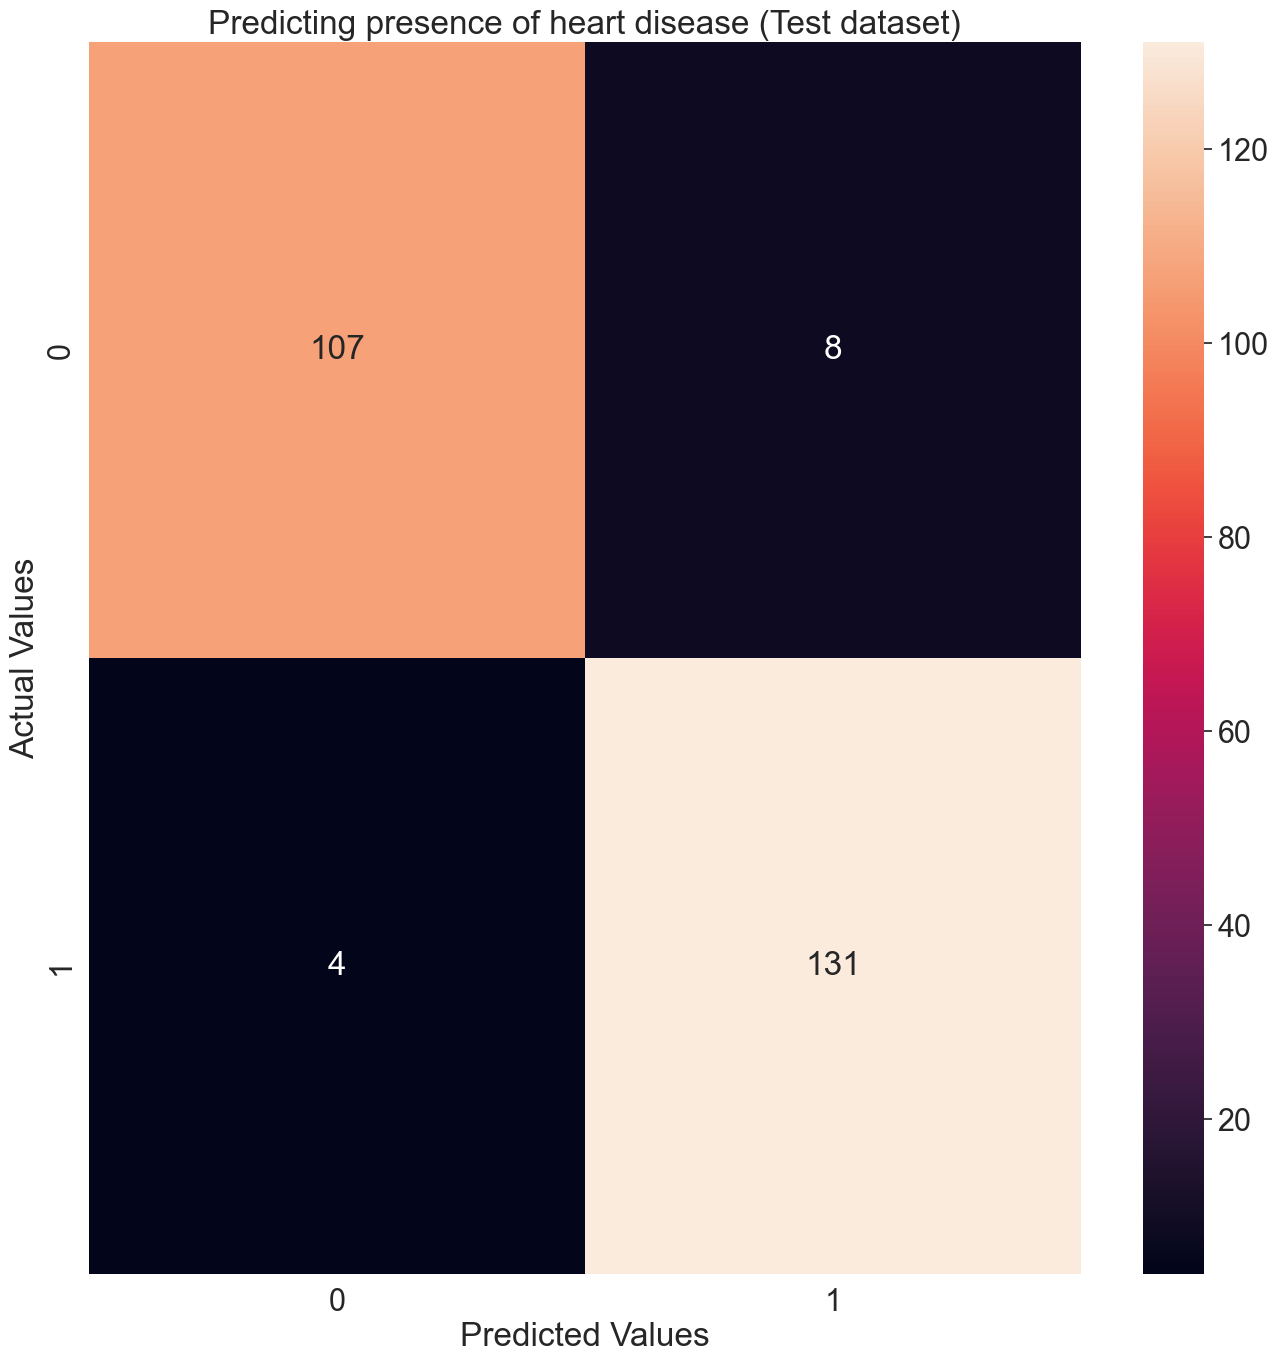

In [11]:
y_pred_log_reg = log_reg.predict(x_test)

cnf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

display_confusion_matrix(cnf_matrix_log_reg, title="Predicting presence of heart disease (Test dataset)")
print_model_statistics(cnf_matrix_log_reg)

#### Analysis of model's performance

adslfjakldsjfkljalkdsjfkljalksdjfkljasdlkjflkajdl

### Decision Tree model

#### Fitting model

In [12]:
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=seed)

dec_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=55886695)

#### Display Decision Tree

[Text(0.5294117647058824, 0.9166666666666666, 'slope_Undefined <= 0.5\ngini = 0.483\nsamples = 750\nvalue = [305.0, 445.0]\nclass = False'),
 Text(0.47058823529411764, 0.75, 'slope_Upsloping <= 0.5\ngini = 0.403\nsamples = 618\nvalue = [173.0, 445.0]\nclass = False'),
 Text(0.17647058823529413, 0.5833333333333334, 'maxheartrate <= 85.0\ngini = 0.034\nsamples = 400\nvalue = [7.0, 393.0]\nclass = False'),
 Text(0.11764705882352941, 0.4166666666666667, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = True'),
 Text(0.23529411764705882, 0.4166666666666667, 'oldpeak <= 5.45\ngini = 0.03\nsamples = 399\nvalue = [6, 393]\nclass = False'),
 Text(0.11764705882352941, 0.25, 'isMale <= 0.5\ngini = 0.011\nsamples = 352\nvalue = [2, 350]\nclass = False'),
 Text(0.058823529411764705, 0.08333333333333333, 'gini = 0.04\nsamples = 98\nvalue = [2.0, 96.0]\nclass = False'),
 Text(0.17647058823529413, 0.08333333333333333, 'gini = 0.0\nsamples = 254\nvalue = [0, 254]\nclass = False'),
 Text(0.3529411764705

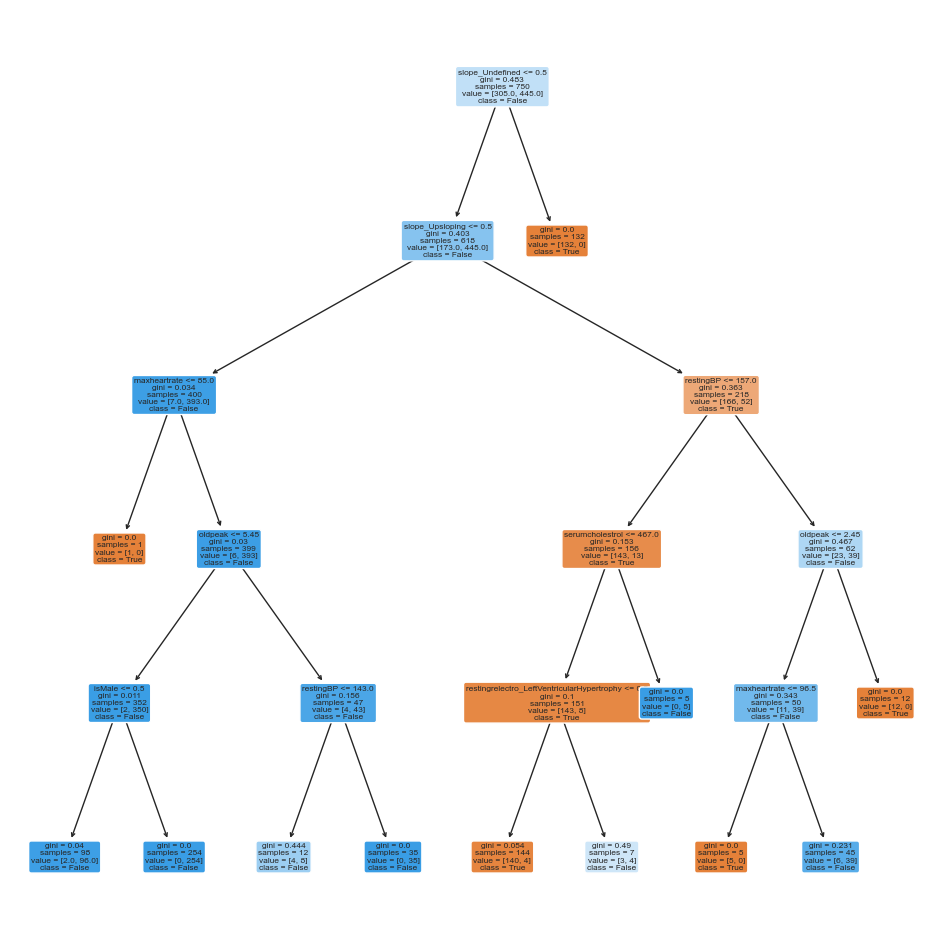

In [13]:
f = plt.figure(figsize=(12,12))
plot_tree(
    dec_tree, filled=True, rounded=True,
    fontsize=6,
    feature_names=col_pred,
    class_names=["True", "False"]
)

#### Performace of model

Test size: 250
Model accuracy: 0.94400


Negative Count: 115
False Negative Rate (FPR): 	0.07407
True Negative Rate (FPR): 	0.91304


Positive Count: 135
False Positive Rate (FPR): 	0.03478
True Positive Rate (FPR): 	0.97037


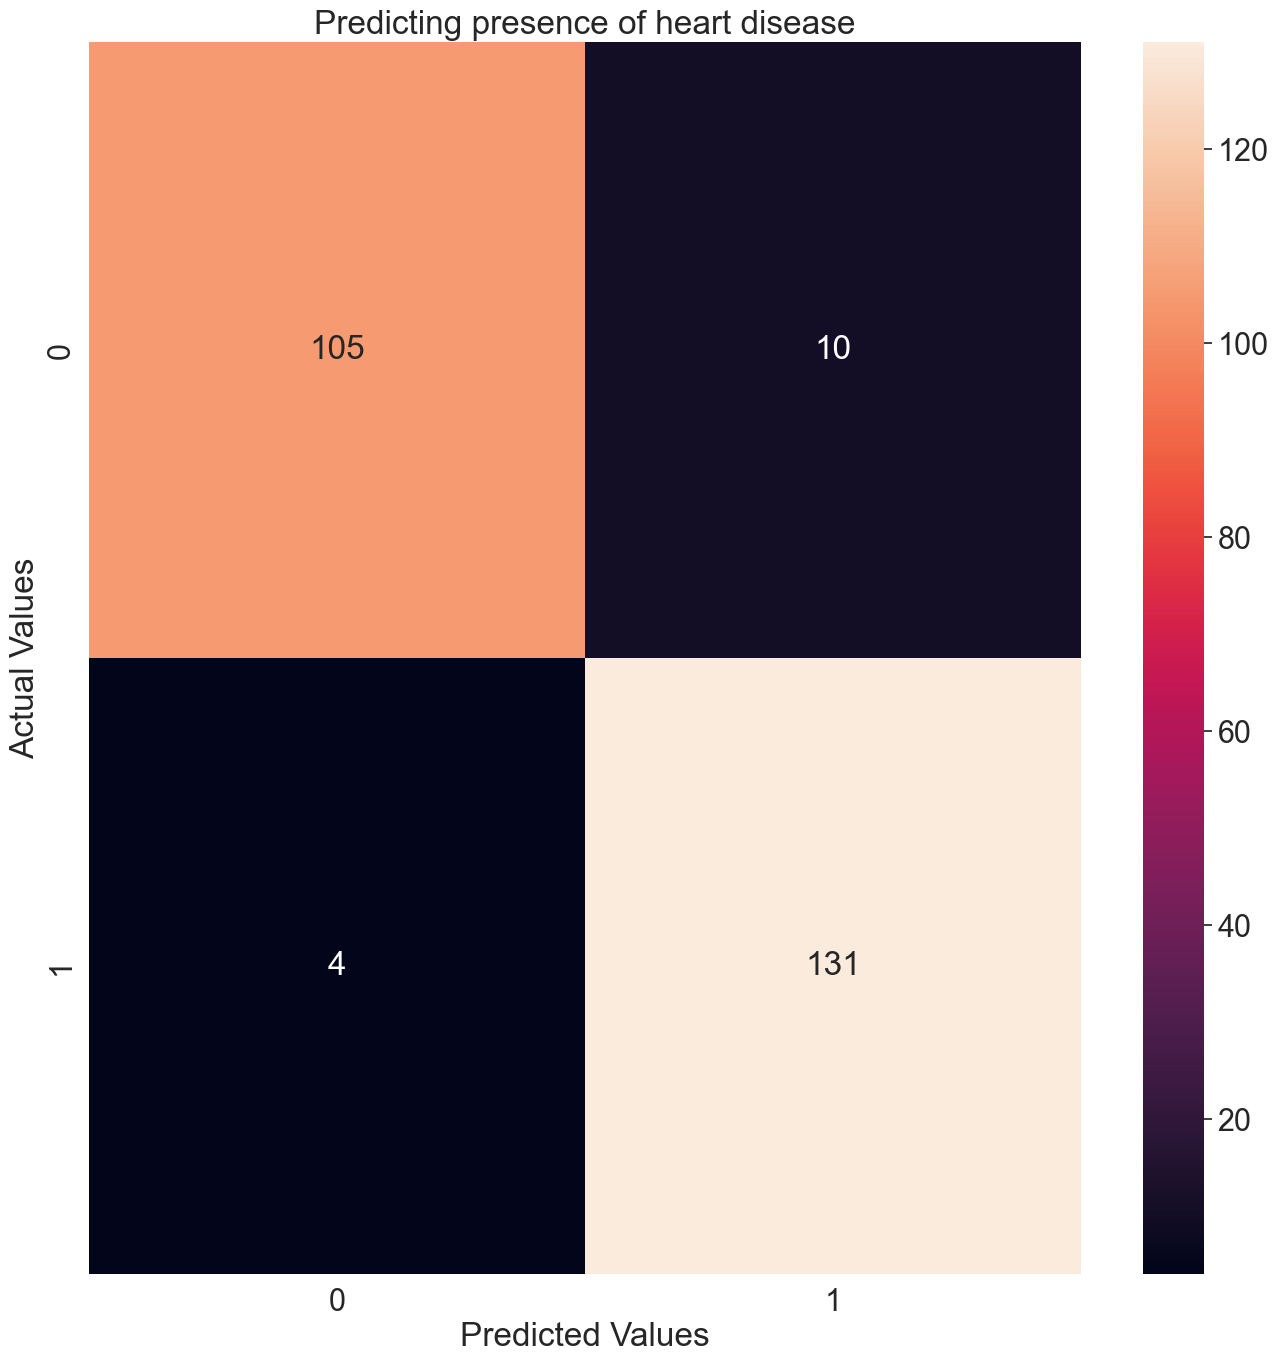

In [14]:
y_pred_dec_tree = dec_tree.predict(x_test)

cnf_matrix_dec_tree = confusion_matrix(y_test, y_pred_dec_tree)

display_confusion_matrix(cnf_matrix_dec_tree)
print_model_statistics(cnf_matrix_dec_tree)

#### Analysis of model's performance

dlkfjalksdjflhaiogopqwoiqiewhiqhihiwhgihrighihri

### Random Forest Model

#### Fitting Model

In [15]:
rforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=seed)

rforest.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=55886695)

#### Performance of Model

Test size: 250
Model accuracy: 0.95600


Negative Count: 115
False Negative Rate (FPR): 	0.05926
True Negative Rate (FPR): 	0.93043


Positive Count: 135
False Positive Rate (FPR): 	0.02609
True Positive Rate (FPR): 	0.97778


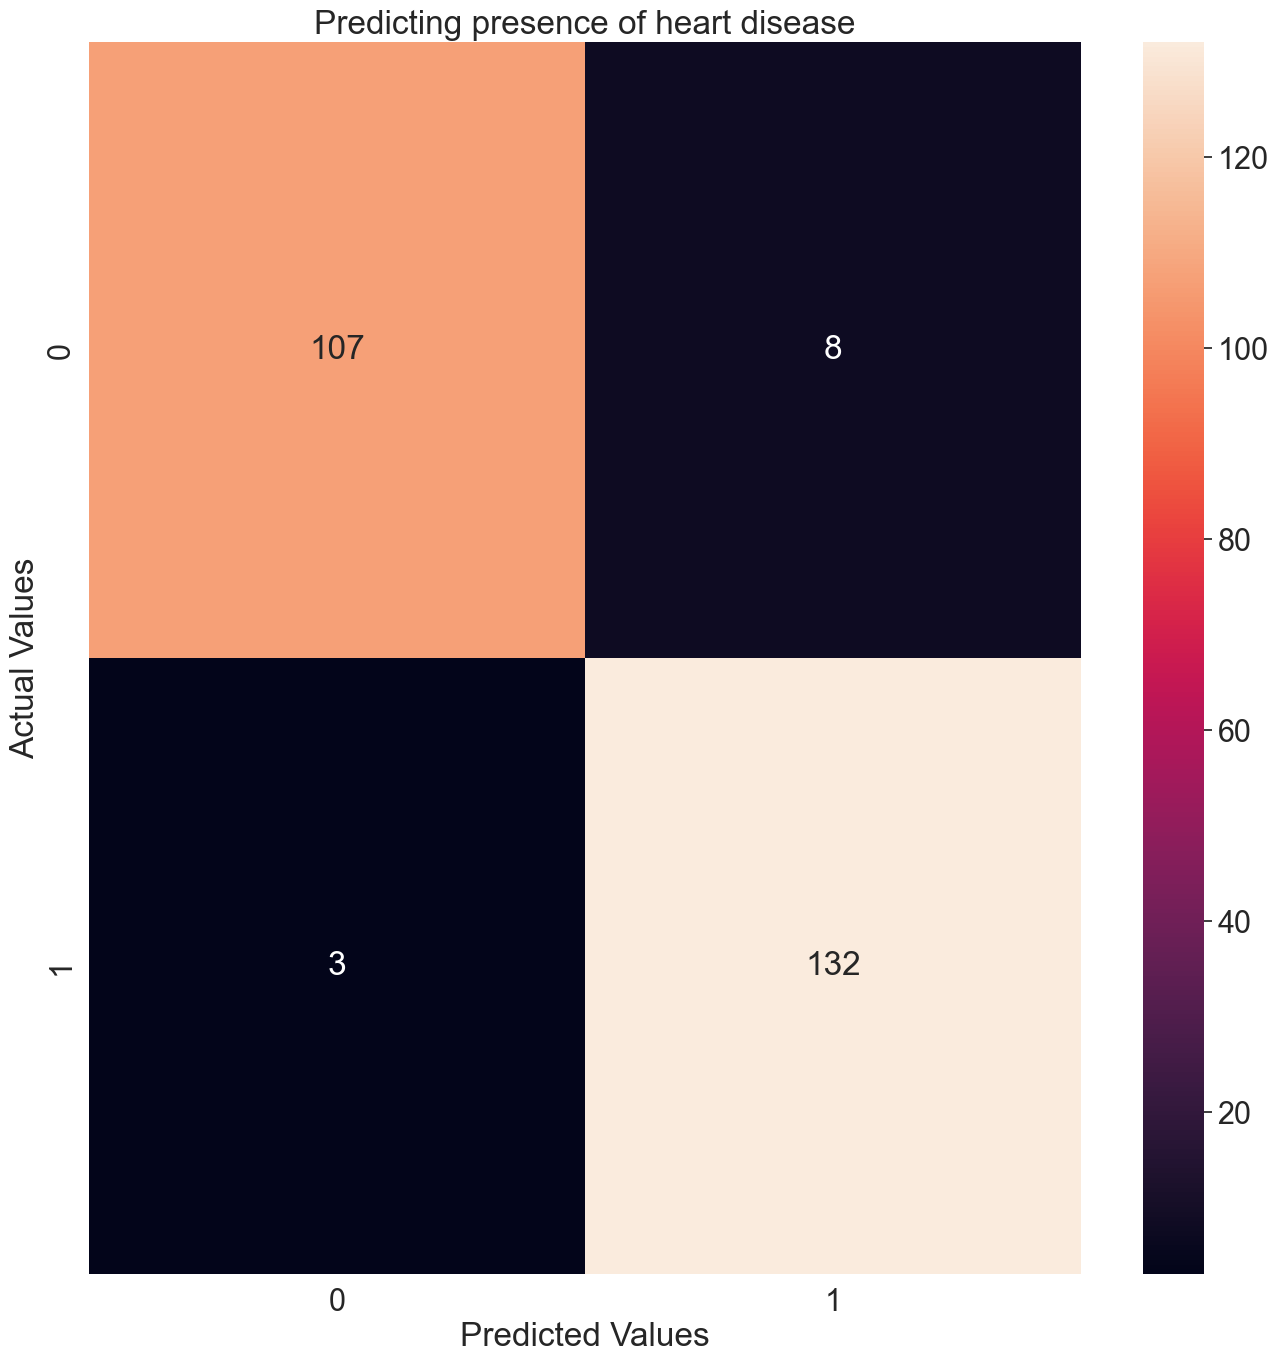

In [16]:
y_pred_rforest = rforest.predict(x_test)

cnf_matrix_rforest = confusion_matrix(y_test, y_pred_rforest)

display_confusion_matrix(cnf_matrix_rforest)
print_model_statistics(cnf_matrix_rforest)

#### Optimizing parameters for random forest classifier

In [17]:
param_grid = {
    'n_estimators': np.arange(100,1001,100),
    'max_depth': np.arange(4, 11),
}

hpGrid = GridSearchCV(
    RandomForestClassifier(random_state=seed),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
)

hpGrid.fit(x_train, y_train)

best_rforest = hpGrid.best_estimator_
best_rforest

RandomForestClassifier(max_depth=8, random_state=55886695)

#### Performance of optimized model

Test size: 250
Model accuracy: 0.97200


Negative Count: 115
False Negative Rate (FPR): 	0.04444
True Negative Rate (FPR): 	0.94783


Positive Count: 135
False Positive Rate (FPR): 	0.00870
True Positive Rate (FPR): 	0.99259


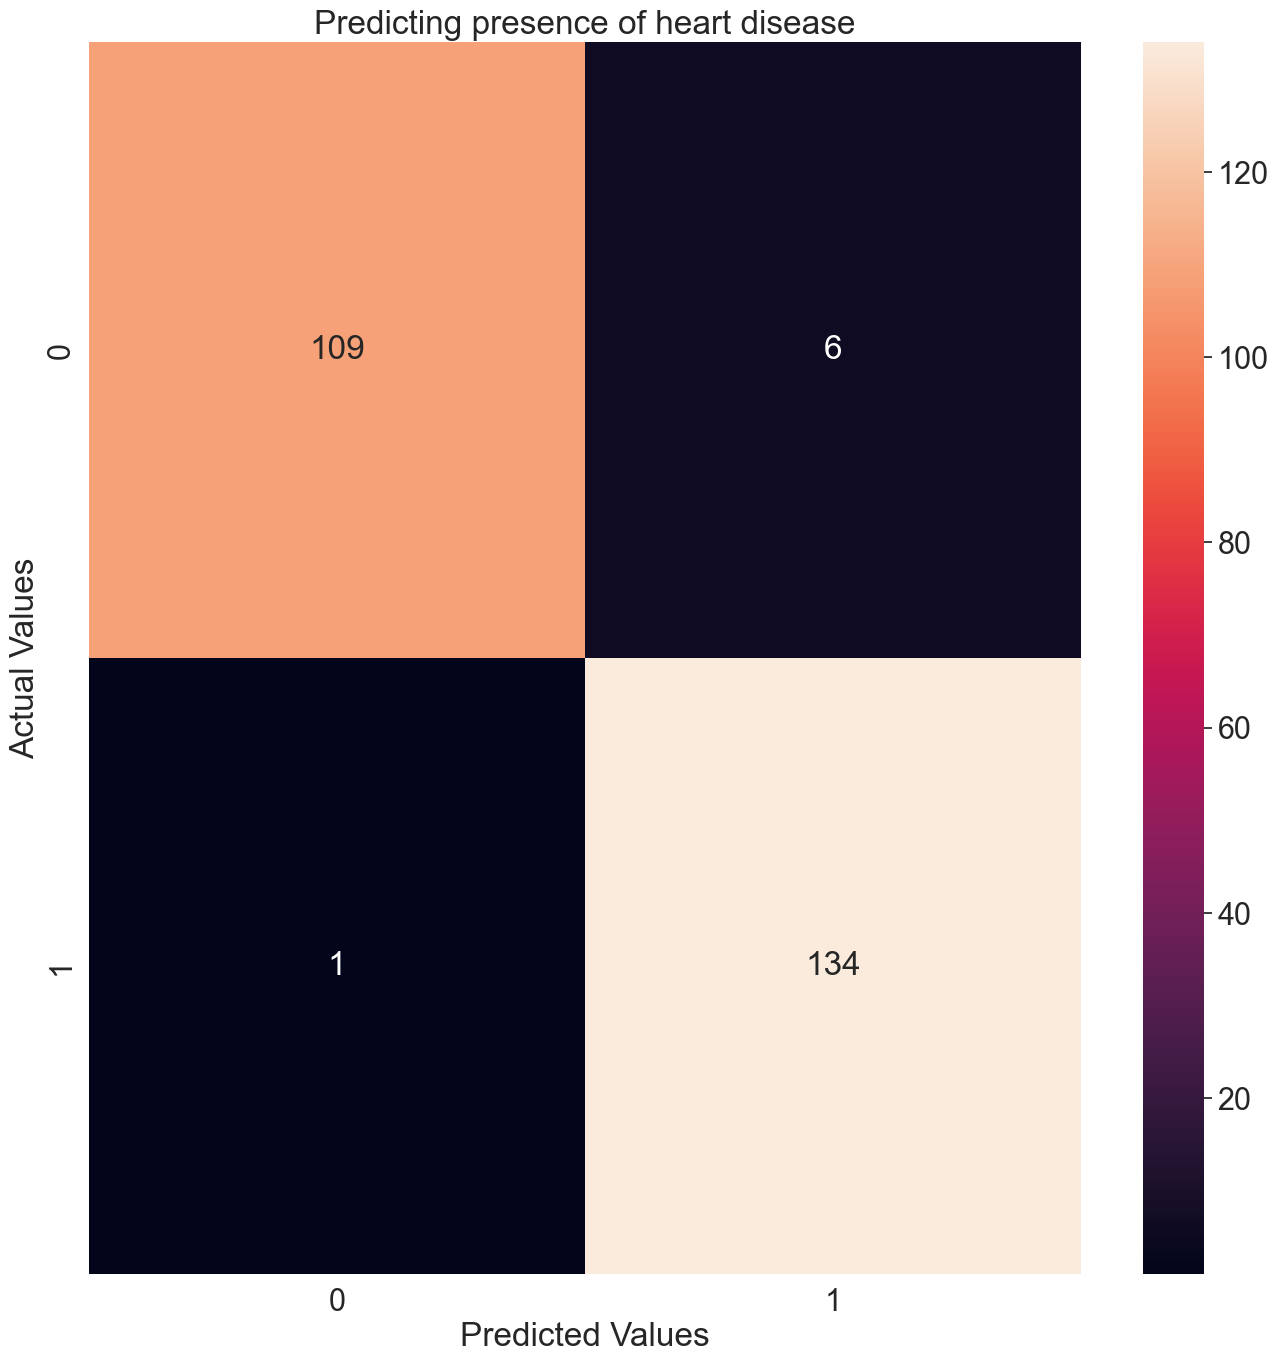

In [18]:
y_pred_best_rforest = best_rforest.predict(x_test)

cnf_matrix_best_rforest = confusion_matrix(y_test, y_pred_best_rforest)

display_confusion_matrix(cnf_matrix_best_rforest)
print_model_statistics(cnf_matrix_best_rforest)

#### Analysis of model's performance

dlkfjalksdjflhaiogopqwoiqiewhiqhihiwhgihrighihri

## Reflection

### Summary of each models performance

In [21]:
print("Logistic Regression model\n")
print_model_statistics(cnf_matrix_log_reg)
print('\n', '*' * 50, '\n', sep='')

print("Decision Tree Classifier model\n")
print_model_statistics(cnf_matrix_dec_tree)
print('\n', '*' * 50, '\n', sep='')

print("Random Forest Classifier model\n")
print_model_statistics(cnf_matrix_best_rforest)
print('\n', '*' * 50, '\n', sep='')

Logistic Regression model

Test size: 250
Model accuracy: 0.95200


Negative Count: 115
False Negative Rate (FPR): 	0.05926
True Negative Rate (FPR): 	0.93043


Positive Count: 135
False Positive Rate (FPR): 	0.03478
True Positive Rate (FPR): 	0.97037

**************************************************

Decision Tree Classifier model

Test size: 250
Model accuracy: 0.94400


Negative Count: 115
False Negative Rate (FPR): 	0.07407
True Negative Rate (FPR): 	0.91304


Positive Count: 135
False Positive Rate (FPR): 	0.03478
True Positive Rate (FPR): 	0.97037

**************************************************

Random Forest Classifier model

Test size: 250
Model accuracy: 0.97200


Negative Count: 115
False Negative Rate (FPR): 	0.04444
True Negative Rate (FPR): 	0.94783


Positive Count: 135
False Positive Rate (FPR): 	0.00870
True Positive Rate (FPR): 	0.99259

**************************************************



### Conclusion

asdfhajlsdhfkjhajkdshfkjhadkjhkzchxuzicvuiyzicyv